# Tarea: Precio de una Criptomoneda (ETHERIUM)

Esta tarea se enfoca en la aplicación de técnicas de aprendizaje profundo, específicamente utilizando redes neuronales recurrentes de memoria a largo plazo (LSTM, por sus siglas en inglés), para realizar predicciones del precio de una criptomoneda (Ethereum). Las redes LSTM son una variante especializada de redes neuronales recurrentes diseñadas para capturar patrones secuenciales en datos temporales, haciéndolas particularmente adecuadas para modelar series de tiempo, como las fluctuaciones de precios en el mercado de criptomonedas.

El objetivo principal es desarrollar un modelo predictivo robusto que pueda capturar la complejidad y la dinámica del mercado del Ethereum. Para ello, exploraremos diferentes estrategias de preprocesamiento de datos, horizontes temporales, arquitecturas de redes LSTM y técnicas de optimización para entrenar y evaluar nuestros modelos. Además, evaluaremos el rendimiento del modelo en función de métricas de evaluación específicas, como el error medio absoluto (MAE) o el error cuadrático medio (MSE), para determinar su precisión y capacidad de generalización, así como los errores máximos y mínimos.

A través de este proyecto, buscamos no solo comprender mejor la naturaleza volátil del mercado del Ethereum, sino también explorar el potencial de las redes LSTM como herramienta para realizar predicciones precisas en este entorno complejo y dinámico.

In [3]:
#!pip install ccxt

In [4]:
# Comenzamos importando las librerías necesarias
import numpy as np
np.random.seed(4)
import pandas as pd
import os

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos y manejo de series de tiempo
import ccxt

from datetime import datetime, timedelta
import time

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Modelo
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

2024-05-10 08:09:38.363477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Cargar los datos

In [5]:
# Configurar el exchange
exchange = ccxt.binance()

# Definir el par de trading y el intervalo de tiempo
symbol = 'ETH/USDT'

# Intervalo de tiempo
timeframe = '5m'

# Calcular las fechas de inicio y fin
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Convertir las fechas a timestamps correspondientes en milisegundos
since = int(start_date.timestamp() * 1000)
until = int(end_date.timestamp() * 1000)

# Obtener los datos en lotes de 1000 registros
batch_size = 1000
bars = []
current_since = since

while current_since < until:
    current_until = min(current_since + batch_size * 300000, until)  #  Se multiplica por 300000 para convertirlo en milisegundos, formato de tiempo utilizado por el exchange para los datos OHLCV
    ohlcv_batch = exchange.fetch_ohlcv(symbol, timeframe, current_since, current_until)
    bars += ohlcv_batch
    current_since = ohlcv_batch[-1][0] + 300000  # Actualizar el since al final del batch

# Convertir los datos a un DataFrame de pandas
df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Establecer la columna de tiempo como índice
df.set_index('timestamp', inplace=True)

# Imprimir el DataFrame
df


,open,high,low,close,volume
timestamp,,,,,
2023-05-11 15:10:00,1802.19,1802.32,1795.15,1795.82,2210.7372
2023-05-11 15:15:00,1795.82,1799.58,1794.96,1799.58,1870.4004
2023-05-11 15:20:00,1799.57,1804.86,1798.60,1804.33,3229.6193
2023-05-11 15:25:00,1804.34,1804.34,1801.70,1803.40,1836.8548
2023-05-11 15:30:00,1803.40,1807.57,1803.39,1805.83,1833.8704
...,...,...,...,...,...
2024-05-10 14:50:00,2958.15,2959.53,2924.60,2936.40,20540.0212
2024-05-10 14:55:00,2936.40,2947.73,2924.18,2935.78,9051.3832
2024-05-10 15:00:00,2935.79,2945.00,2927.80,2942.00,6564.1231


In [6]:
# Crear la ruta para la carpeta "data" dentro del directorio actual
ruta_data = os.path.join(".", "data")

# Verificar si la carpeta "data" existe
if not os.path.exists(ruta_data):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_data)

# Guardar los datos en la carpeta "data"
ruta_archivo = os.path.join(ruta_data, "ETH_5m.csv")
df.to_csv(ruta_archivo, index=False) 

## 2. Análisis exploratorio

### 2.1 Comprender las variables del dataset

- **Open (Apertura):** Es el precio de apertura de la criptomoneda en el período de tiempo dado (por ejemplo, el precio al comienzo de una hora o un día).

- **High (Máximo):** Representa el precio más alto alcanzado por la criptomoneda durante el período de tiempo dado.

- **Low (Mínimo):** Es el precio más bajo alcanzado por la criptomoneda durante el período de tiempo dado.

- **Close (Cierre):** Es el precio de cierre de la criptomoneda al final del período de tiempo dado.

- **Volume (Volumen):** Indica la cantidad total de la criptomoneda que se ha negociado durante el período de tiempo dado. Es una medida de la actividad comercial en el mercado durante ese intervalo de tiempo.

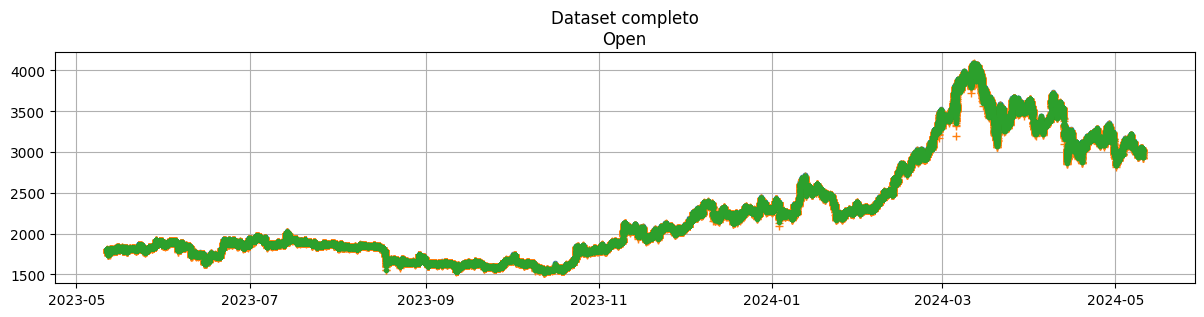

In [7]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset completo\nOpen")
ax1.plot(df.high,marker='.',linewidth=0)
ax1.plot(df.low,marker='+',linewidth=0)
ax1.plot(df.open,marker='.',linewidth=0)
plt.grid(True)
plt.show()

In [8]:
set_entrenamiento = df[:'2023'].iloc[:,1:2]
set_validacion = df['2024':].iloc[:,1:2]

In [9]:
set_entrenamiento.shape[0]

67498

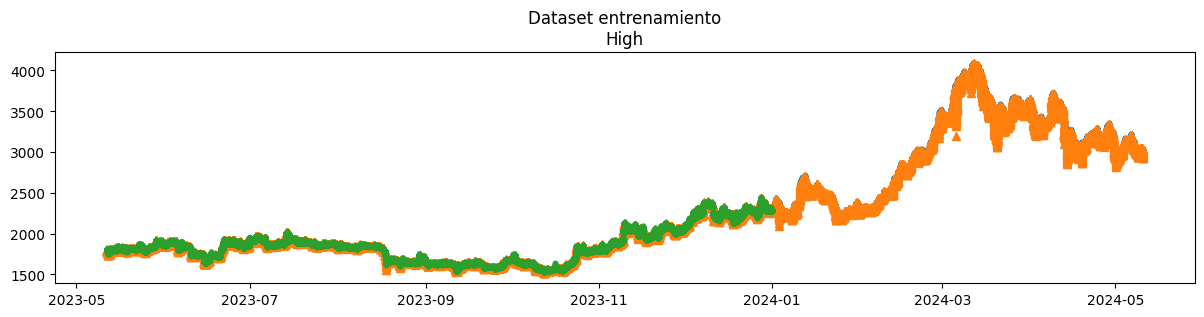

In [10]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset entrenamiento\nHigh")
ax1.plot(df.high,marker='.',linewidth=0)
ax1.plot(df.low,marker='^',linewidth=0)
ax1.plot( set_entrenamiento.high, marker = '.', linewidth = 0 )
plt.show()

### 2.2 Detección de valores faltantes e intervalos regulares

In [11]:
# Asegurarse de que la serie de tiempo esté ordenada por marcas de tiempo si aún no lo está
df = df.sort_index()

# Verificar que todos los intervalos de 5 minutos estén presentes
intervalos_esperados = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5T')
intervalos_faltantes = intervalos_esperados.difference(df.index)
if len(intervalos_faltantes) == 0:
    print("Todos los intervalos de 5 minutos están presentes.")
else:
    print("Faltan intervalos de 5 minutos en la serie de tiempo.")

# Verificar la regularidad de los intervalos
diferencia_intervalos = df.index.to_series().diff().dropna()
if (diferencia_intervalos == pd.Timedelta(minutes=5)).all():
    print("La serie de tiempo tiene intervalos regulares de 5 minutos.")
else:
    print("La serie de tiempo tiene intervalos irregulares.")


Todos los intervalos de 5 minutos están presentes.
La serie de tiempo tiene intervalos regulares de 5 minutos.


Podemos ver que todos los intervalos de 5 minutos están presentes y que la serie de tiempo está bien definida, con intervalos de 5 minutos, sin valores faltantes.

### 2.3 Escalamiento de datos y construcción de los conjuntos de entrenamiento y validación

In [12]:
sc = MinMaxScaler( feature_range = (0,1) )
set_entrenamiento_escalado = sc.fit_transform( set_entrenamiento )

In [13]:
time_step = 144 # <-------- parametro: numero de valores a usar para predecir el siguiente (12 horas)
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [14]:
X_train.shape, Y_train.shape

((67354, 144), (67354,))

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
X_train.shape, Y_train.shape

((67354, 144, 1), (67354,))

## 3. Modelo LSTM

### 3.1 Construcción del modelo

In [17]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 120    # <-------- parametro: numero de neuronas

In [18]:
modelo = Sequential()
modelo.add( LSTM( units = na, input_shape = dim_entrada ) )
modelo.add( Dense( units = dim_salida ))

2024-05-10 08:10:33.269119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-10 08:10:33.270191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-10 08:10:33.271565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
# Configuración del optimizador, función de pérdida y métricas
optimizer = Adam()
loss = MeanSquaredError()
metrics = [MeanSquaredError(), MeanAbsoluteError()]  # Agregar MAD como métrica adicional

# Compilar el modelo con la configuración especificada
modelo.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### 3.2 Entrenamiento del modelo

In [20]:
%time historial = modelo.fit( X_train, Y_train, epochs = 15, batch_size = 32, verbose = 1 )

Epoch 1/15


2024-05-10 08:10:33.704677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-10 08:10:33.705898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-10 08:10:33.707357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2105/2105 [==============================] - 97s 45ms/step - loss: 5.4324e-04 - mean_squared_error: 5.4319e-04 - mean_absolute_error: 0.0057
Epoch 2/15
2105/2105 [==============================] - 95s 45ms/step - loss: 2.8291e-05 - mean_squared_error: 2.8291e-05 - mean_absolute_error: 0.0035
Epoch 3/15
2105/2105 [==============================] - 99s 47ms/step - loss: 2.2163e-05 - mean_squared_error: 2.2164e-05 - mean_absolute_error: 0.0031
Epoch 4/15
2105/2105 [==============================] - 101s 48ms/step - loss: 1.7497e-05 - mean_squared_error: 1.7496e-05 - mean_absolute_error: 0.0028
Epoch 5/15
2105/2105 [==============================] - 102s 49ms/step - loss: 1.3270e-05 - mean_squared_error: 1.3270e-05 - mean_absolute_error: 0.0024
Epoch 6/15
2105/2105 [==============================] - 100s 48ms/step - loss: 1.0876e-05 - mean_squared_error: 1.0875e-05 - mean_absolute_error: 0.0022
Epoch 7/15
2105/2105 [==============================] - 103s 49ms/step - loss: 9.3313e-06 - mean

### 3.3 Guardar el historial y el modelo

In [21]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
ruta_modelo = os.path.join(".", "model")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo, 'modelo_entrenado4.h5')
modelo.save(path_modelo)

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, 'historial_entrenamiento4.csv')  # Corregir la ruta aquí
historial_df.to_csv(path_historial, index=False)


### 3.4 Validación y evaluación del modelo

In [22]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [23]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array( X_test )
X_test = np.reshape( X_test, (X_test.shape[0],X_test.shape[1],1)  )

In [24]:
X_test.shape, set_validacion.shape

((37479, 144, 1), (37623, 1))

In [25]:
prediccion = modelo.predict( X_test )
prediccion = sc.inverse_transform(prediccion)

   1/1172 [..............................] - ETA: 11:14

2024-05-10 08:35:52.975631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-10 08:35:52.978945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-10 08:35:52.981215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1172/1172 [==============================] - 22s 18ms/step


In [26]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:], columns=['high'])

In [27]:
df_prediccion['high'][0]

2306.4207

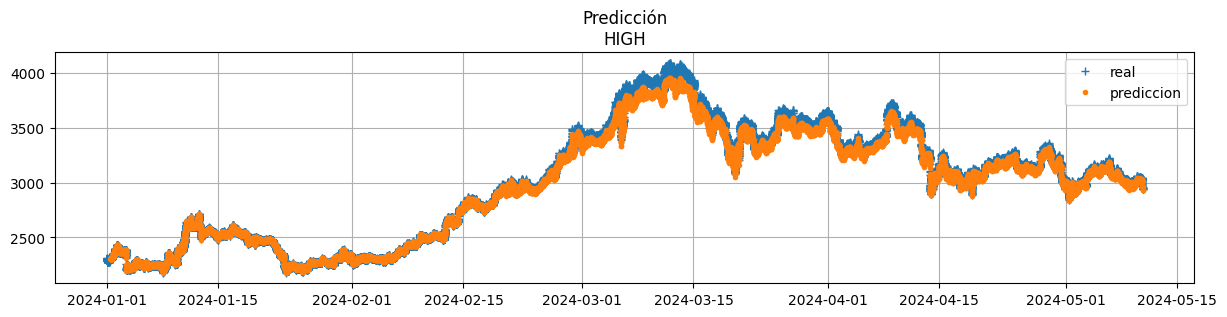

In [30]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción\nHIGH")
ax1.plot( set_validacion.high, marker = '+', linewidth = 0 )
ax1.plot( df_prediccion['high'], marker = '.', linewidth = 0 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [31]:
maximo = np.max(np.abs(set_validacion.high[:df_prediccion.shape[0]+time_step] - df_prediccion['high']))
minimo_valor = np.min(np.abs(set_validacion.high[:df_prediccion.shape[0]+time_step] - df_prediccion['high']))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)


La diferencia máxima es 183.65179687499995
La diferencia mínima es 0.0007812499998181011


El desempeño del modelo es notablemente bueno, como se puede observar en la gráfica donde las predicciones siguen de cerca el comportamiento real de la serie de tiempo. Al analizar las diferencias entre las predicciones y los valores reales, se puede notar que los errores oscilan en un rango desde aproximadamente 183.65 USD hasta fracciones de centavos.